In [ ]:
from google.colab import drive
import tarfile
import keras
import os,shutil, pickle
from keras import layers
from keras import models
from keras.models import Model
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization, Flatten
from keras import optimizers
from keras.utils import np_utils
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

In [ ]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
import random
from tensorflow import keras
from keras.layers import Dense, Input, InputLayer, Flatten
from keras.models import Sequential, Model
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [ ]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError: # If TPU not found
  tpu = None

# Select appropriate distribution strategy
if tpu:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])  
else:
  tpu_strategy = tf.distribute.get_strategy() # Default strategy that works on CPU and single GPU
  print('Running on CPU instead')
print("Number of accelerators: ", tpu_strategy.num_replicas_in_sync)  

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.62.18.82:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.62.18.82:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Running on TPU  ['10.62.18.82:8470']
Number of accelerators:  8


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
IMG_HEIGHT=32
IMG_WIDTH=32

# Resnet50 isolated model

In [ ]:
def pre_trained_isolated_model():
    input = tf.keras.Input(shape=(IMG_HEIGHT,IMG_WIDTH,3))
    efnet = tf.keras.applications.Resnet50(weights='imagenet',
                                                include_top = False, 
                                                input_tensor = input)
    # Now that we apply global max pooling.
    gap = tf.keras.layers.GlobalMaxPooling2D()(efnet.output)

    # add classification layer.
    inter_layer1 = tf.keras.layers.Dense(1024, activation='relu')(gap)
    inter_layer2 = tf.keras.layers.Dropout(rate=.3, seed=123)(inter_layer1)
    output = tf.keras.layers.Dense(120, activation='softmax')(inter_layer2)

    # bind all
    model = tf.keras.Model(efnet.input, output)
    model.compile(
            optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

# **Load The Stanford Dogs Dataset**
The Stanford Dogs Dataset contains images of 120 breeds of dogs from around the world. This dataset has been built using images and annotation from ImageNet for the task of fine-grained image categorization.
Contents of the dataset:

Number of categories: 120
Number of images: 20,580
Annotations: Class labels, Bounding boxes

The dataset can be downloaded from http://vision.stanford.edu/aditya86/ImageNetDogs/.

In [ ]:
def create_dataset(dataset_folder):  
    img_data_array=[]
    class_name=[]
   
    for dir1 in os.listdir(dataset_folder):
        print(dir1)
        for file in os.listdir(os.path.join(dataset_folder, dir1)):
       
            image_path= os.path.join(dataset_folder, dir1,  file)
            image= cv2.imread( image_path, cv2.COLOR_BGR2RGB)
            image=cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH),interpolation = cv2.INTER_AREA)
            image=np.array(image)
            image = image.astype('float32')
            image = (image-127.5) / 127.5 
            img_data_array.append(image)
            class_name.append(dir1)
    return img_data_array, class_name

In [ ]:
#load data
with tpu_strategy.scope():
  dataset_folder=r'/content/drive/MyDrive/Standford_Dogs_dataset/Images/'
  x_train, y_train = create_dataset(dataset_folder)

n02085620-Chihuahua
n02085936-Maltese_dog
n02086079-Pekinese
n02086240-Shih-Tzu
n02088094-Afghan_hound
n02088238-basset
n02088364-beagle
n02088632-bluetick
n02089078-black-and-tan_coonhound
n02089867-Walker_hound
n02090379-redbone
n02090622-borzoi
n02091032-Italian_greyhound
n02091134-whippet
n02091467-Norwegian_elkhound
n02091831-Saluki
n02092339-Weimaraner
n02093256-Staffordshire_bullterrier
n02093428-American_Staffordshire_terrier
n02093647-Bedlington_terrier
n02093754-Border_terrier
n02093991-Irish_terrier
n02094258-Norwich_terrier
n02094433-Yorkshire_terrier
n02095314-wire-haired_fox_terrier
n02095570-Lakeland_terrier
n02095889-Sealyham_terrier
n02096051-Airedale
n02096177-cairn
n02096437-Dandie_Dinmont
n02096585-Boston_bull
n02097047-miniature_schnauzer
n02097130-giant_schnauzer
n02097298-Scotch_terrier
n02097474-Tibetan_terrier
n02097658-silky_terrier
n02098105-soft-coated_wheaten_terrier
n02098286-West_Highland_white_terrier
n02098413-Lhasa
n02099267-flat-coated_retriever
n0209

In [ ]:
target_dict = {k: v for v, k in enumerate(np.unique(y_train))}
target_val =  [target_dict[y_train[i]] for i in range(len(y_train))]

In [ ]:
x=np.array(x_train, np.float32)
y=np.array(list(map(int,target_val)), np.float32)

In [ ]:
print(x.shape, y.shape)

(20580, 32, 32, 3) (20580,)


In [ ]:
def train_val_by_metric(history,metric):
  history_dict = history.history
  #history_dict.keys()
  values = history_dict[metric]
  val_values = history_dict['val_'+metric]

  epochs = range(1, len(values) + 1)
  
  plt.plot(epochs, values, 'bo', label= 'Training '+metric)
  plt.plot(epochs, val_values, 'b', label= 'Validation '+metric)
  metricTitle = 'Loss' if metric == 'loss' else 'Accuracy'
  plt.title('Training and validation '+metricTitle)
  plt.xlabel('Epochs')
  plt.ylabel(metricTitle)
  plt.legend()
  plt.show()
  
###################################################

def train_val_plot(history):
  train_val_by_metric(history,'loss')
  train_val_by_metric(history,'accuracy')

In [ ]:
with tpu_strategy.scope():
  isolated_model = pre_trained_isolated_model()
  history = isolated_model.fit(x, y, 
                      batch_size=128, epochs=100,
                      validation_split=0.2)

16719872/16705208 [==============================] - 0s 0us/step
Epoch 1/100
129/129 [==============================] - 71s 217ms/step - loss: 4.7059 - accuracy: 0.0185 - val_loss: 13.0626 - val_accuracy: 0.0000e+00
Epoch 2/100
129/129 [==============================] - 5s 36ms/step - loss: 4.4151 - accuracy: 0.0371 - val_loss: 18.8941 - val_accuracy: 0.0000e+00
Epoch 3/100
129/129 [==============================] - 5s 36ms/step - loss: 4.2599 - accuracy: 0.0465 - val_loss: 15.1450 - val_accuracy: 0.0000e+00
Epoch 4/100
129/129 [==============================] - 5s 37ms/step - loss: 4.1575 - accuracy: 0.0565 - val_loss: 12.8156 - val_accuracy: 0.0000e+00
Epoch 5/100
129/129 [==============================] - 5s 37ms/step - loss: 4.0669 - accuracy: 0.0671 - val_loss: 21.3325 - val_accuracy: 0.0000e+00
Epoch 6/100
129/129 [==============================] - 5s 36ms/step - loss: 3.9746 - accuracy: 0.0776 - val_loss: 19.1774 - val_accuracy: 0.0000e+00
Epoch 7/100
129/129 [==================

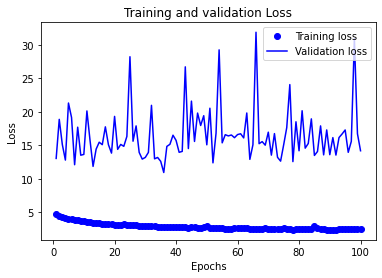

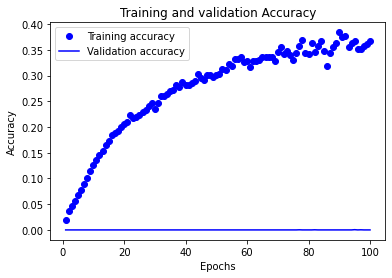

In [ ]:
train_val_plot(history)

In [ ]:
model_path = "/content/drive/MyDrive/"
isolated_model.save(model_path+"Resnet50_isolated_model_100epoch_stanford_dogs.h5")